In [4]:
import numpy as np
import cv2
import torch
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import cupy as cp
import time
import multiprocessing as mp

In [10]:
np.random.seed(66)
class GMM():
    def __init__(self,data,k,device,iter_times=10,eps=1e-6,n=8) -> None:
        self.data = data
        self.eps = eps
        self.k = k 
        self.n = n
        self.device = device
        self.per_data_nums,self.per_data_dim,self.channel = data.shape
        self.points = data.reshape((self.per_data_nums*self.per_data_dim,self.channel)).astype(float)

        self.iter_times = iter_times
        self.means = np.random.rand(self.k,self.channel)
        self.vars =  np.random.rand(self.k,self.channel,self.channel)
        self.alpha = np.random.rand(self.k)
    def Muti_Gaussian_Density_Function(self,dt,mean,vars):
        n = len(dt)
        div = (2 * np.pi) ** (n / 2) * (abs(np.linalg.det(vars)) ** 0.5)
        expOn = -0.5 * ( np.dot( (dt - mean).T,  np.dot(np.linalg.inv(vars), (dt - mean)) ) )     
        return np.exp(expOn) / div
    def Caculate_Gussian_Density(self,res):
        data = res[0]
        mat = res[1]
        for j,x in enumerate(data):
            temp , tempP = 0 , 0
            for i in range(self.k):
                tempP = self.Muti_Gaussian_Density_Function(x,self.means[i],self.vars[i])
                temp += tempP 
                mat[j][i] = self.alpha[i] * tempP
            mat[j] /= temp
        return mat
    def Data_Split(self,n):
        lens = len(self.points)
        part_nums = math.floor(lens / n)
        left_nums = lens % n
        split_array = []
        for j in range(n):
            if(j == n-1):
                split_array.append([j*part_nums,j*part_nums+part_nums+left_nums-1])
            else:
                split_array.append([j*part_nums,j*part_nums+part_nums])
        return split_array
    def fit(self):
        # EM algorithm
        # E-step
        mat = np.zeros((len(self.points),self.k))
        for iter in tqdm(range(self.iter_times)):
            pool = mp.Pool(processes=self.n)
            start = time.time()
            split_array = self.Data_Split(self.n)
            data_list = []
            for mm in split_array:
                dict1 =  {0:self.points[mm[0]:mm[1],:] , 1:mat[mm[0]:mm[1],:]}
                data_list.append(dict1)
            res = pool.map(self.Caculate_Gussian_Density,data_list)
            for t in range(len(split_array)):
                mm = split_array[t]
                mat[mm[0]:mm[1],:] = res[t]
            pool.close()
            pool.join()
            end = time.time()
            print('step1 cost:{:.3f}s'.format(end-start))
            start = time.time()
            for i in range(self.k):
                # updata means
                self.means[i] = np.dot(mat[:,i].T,self.points) / np.sum(mat[:,i])

                # updata vars
                temp = np.zeros(self.vars[0].shape)
                for j in range(self.per_data_nums * self.per_data_dim):
                    data = (self.points[j] - self.means[i]).reshape(3,1)
                    temp += mat[j][i] * np.dot(data, data.T)
                temp /= np.sum(mat[:, i])
                self.vars[i] = temp 
                self.alpha[i] = np.sum(mat[:, i]) / len(self.points)
            end = time.time()
            print('step2 cost:{:.3f}s'.format(end-start))
        # clustering
        Ans = cp.zeros(len(self.points))
        for j, x in enumerate(self.points):
            temp, tempP = 0, 0
            for i in range(self.k):
                tempP = self.Muti_Gaussian_Density_Function(x, self.means[i], self.vars[i])
                temp += tempP
                mat[j][i] = self.alpha[i] * tempP
            mat[j] /= temp
            Ans[j] = np.argmax(mat[j])
        labels = np.zeros((self.per_data_nums,self.per_data_dim))
        for i in range(self.per_data_nums * self.per_data_dim):
            idx1 = math.floor(i / self.per_data_nums)
            idx2 = i % self.per_data_nums
            labels[idx1,idx2] = Ans[i]

        return labels

  0%|                                                                                                                                                           | 0/10 [00:00<?, ?it/s]

step1 cost:1.012s


 10%|██████████████▋                                                                                                                                    | 1/10 [00:02<00:19,  2.22s/it]

step2 cost:0.829s
step1 cost:0.812s


 20%|█████████████████████████████▍                                                                                                                     | 2/10 [00:04<00:16,  2.10s/it]

step2 cost:0.873s
step1 cost:0.766s


 30%|████████████████████████████████████████████                                                                                                       | 3/10 [00:06<00:14,  2.13s/it]

step2 cost:1.066s
step1 cost:0.846s


 40%|██████████████████████████████████████████████████████████▊                                                                                        | 4/10 [00:08<00:12,  2.06s/it]

step2 cost:0.759s
step1 cost:0.975s


 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 5/10 [00:10<00:10,  2.06s/it]

step2 cost:0.731s
step1 cost:0.848s


 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 6/10 [00:12<00:08,  2.03s/it]

step2 cost:0.752s
step1 cost:0.793s


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7/10 [00:14<00:06,  2.03s/it]

step2 cost:0.851s
step1 cost:0.875s


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 8/10 [00:16<00:04,  2.03s/it]

step2 cost:0.838s
step1 cost:0.834s


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 9/10 [00:18<00:02,  2.05s/it]

step2 cost:0.908s
step1 cost:0.902s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.06s/it]

step2 cost:0.818s


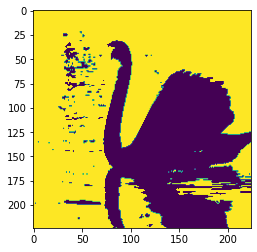

In [12]:
device = torch.device('cuda')
img = cv2.imread(r'./8068.jpg')
img = cv2.resize(img ,(224 ,224)) / 255.
# img = torch.tensor(img,dtype=torch.float).to(device)
model = GMM(img,2,device)
label = model.fit()
plt.imshow(label)
plt.savefig('./out.jpg')